# maysics.explainer模块使用说明

explainer模块包含一个函数

|名称|作用|
|---|---|
|sense|灵敏度分析|

explainer模块包含四个类

|名称|作用|
|---|---|
|Error|误差分析|
|Lime|局部代理|
|SHAP|SHAP值|
|Shapley|Shapley值|

## 灵敏度分析：sense
对函数$f(r)$，其中$r=(x_{0},x_{1},...,x_{n})$
<br>第i个特征在$r_{0}$处的灵敏度：$s(x_{i},r_{0})=\frac{dy}{dx_{i}}\frac{x_{i}}{y}$，$r=r_{0}$
<br>函数有两个输入参数：```func```、```x0```
<br>一个默认参数：```acc=0.1```，表示求导精度

### DEMO 1-1：求非批量输入函数$f(x,y)=x^{2}+y^{2}$在$(1,2)$处$x$和$y$的灵敏度

In [1]:
from maysics.explainer import sense

def f(x):
    return x[0]**2 + x[1]**2

sense(f, [1, 2])

array([0.38, 1.56])

### DEMO 1-2：求批量输入函数$f(x,y)=x^{2}+y^{2}$在${(1,2),(2,3)}$处$x$和$y$的灵敏度

In [2]:
from maysics.explainer import sense

def f(x):
    return x[:, 0]**2 + x[:, 1]**2

sense(f, [[1, 2], [2, 3]])

array([[0.38      , 1.56      ],
       [0.6       , 1.36153846]])

<br></br>
## 误差分析：Error
包含十种误差函数

### DEMO 2-1：求数据集和函数$f(x)=2x$之间的各种误差

In [3]:
from maysics.explainer import Error
import numpy as np

def f(x):
    return 2 * x

np.random.seed(100)
data = np.arange(0, 5, 1)
target = data * 2 + np.random.rand(data.shape[0]) * 0.2 - 0.1

error = Error(f)
error.fit(data, target)

print('绝对值列表：', error.abs_error)
print('相对误差列表：', error.rel_error)
print('绝对误差从大到小的排序：', error.abs_sort)
print('相对误差从大到小的排序：', error.rel_sort)
print('平均绝对值误差：', error.mae)
print('平均绝对百分比误差：', error.mape)
print('平均平方误差：', error.mse)
print('均方根误差：', error.rmse)
print('绝对误差和：', error.sae)
print('残差平方和：', error.sse)

绝对值列表： [0.00868099 0.04432612 0.01509648 0.06895523 0.09905623]
相对误差列表： [1.         0.0226654  0.00378842 0.01136196 0.01253727]
绝对误差从大到小的排序： [(0.09905622876180509, 4), (0.06895522646398078, 3), (0.044326122981241056, 1), (0.015096481850173316, 2), (0.008680988358193087, 0)]
相对误差从大到小的排序： [(1.0, 0), (0.022665396057144287, 1), (0.012537265373587327, 4), (0.011361959989966327, 3), (0.0037884184099851296, 2)]
平均绝对值误差： 0.047223009683078666
平均绝对百分比误差： 0.21007060796613666
平均平方误差： 0.0033670056429771474
均方根误差： 0.05802590493027358
绝对误差和： 0.23611504841539332
残差平方和： 0.016835028214885736


<br></br>
## 局部代理：Lime
对局部点进行扰动并输入模型得到新的数据集
<br>以新数据集为基础，用最小二乘法拟合出新的线性模型$AX+b$用于局部代替黑盒模型
<br>利用该线性模型对黑盒模型进行解释
<br>预测值$=\Sigma weight + intercept$
### Lime的方法
Lime有三个方法：```fit```、```show```和```savefig```
<br>```fit```方法用于计算
<br>```show```和```savefig```用于绘图，前者显示，后者保存
<br>绘图方法仅适用于表格数据

### DEMO 3-1：求函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$附近的各特征指标

In [4]:
from maysics.explainer import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([1, 0], random_state=100)

print('各个特征贡献：', lime.weight)
print('线性模型系数：', lime.coef)
print('线性模型截距：', lime.intercept)

各个特征贡献： [2.01479352 0.        ]
线性模型系数： [2.01479352 0.00945   ]
线性模型截距： -1.0080730843209873


### DEMO 3-2：用函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$附近的局部代理预测点$(1,0.1)$处的函数值

In [5]:
from maysics.explainer import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([1, 0], random_state=100)

print('原模型：', f([[1, 0.1]]))
print('线性模型：', lime.predict([[1, 0.1]]))

原模型： [1.01]
线性模型： [1.00766544]


### DEMO 3-3：绘制函数$f(x,y)=x^{2}+y^{2}$在点$(2,1)$附近的各特征贡献值图

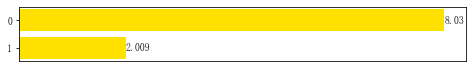

In [6]:
from maysics.explainer import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([2, 1], random_state=100)

# 保留三位小数
lime.show(estimate=3)

### DEMO 3-4：绘制分类模型$f_{1}(x,y)=\frac{1}{1+e^{-x-y}}$，$f_{2}(x,y)=1-f_{1}(x,y)$在点$(-1,2)$附近的各特征贡献值图

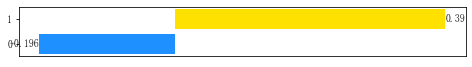

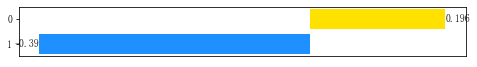

In [7]:
from maysics.explainer import Lime
import numpy as np

def f(x):
    x = x[:, 0] + x[:, 1]
    x = 1 / (1 + np.e**(-x))
    return np.array([x, 1 - x]).T

lime = Lime(f)
lime.fit([-1, 2], random_state=100)
lime.show(estimate=3)

show函数和savefig函数仅支持表格数据的回归和分类模型的可视化

<br></br>
## SHAP值和Shapley值：SHAP和Shapley
使用与Lime类似
### SHAP和Shapley的方法
两个类都有三个方法：```fit```、```show```、```savefig```
<br>SHAP类和Shapley类仅适用于表格数据

### DEMO 4-1：求函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$的SHAP值

In [8]:
from maysics.explainer import SHAP
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shap = SHAP(f)
shap.fit([1, 0])
shap.values

array([1., 0.])

### DEMO 4-2：绘制函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$的SHAP值

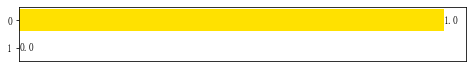

In [9]:
from maysics.explainer import SHAP
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shap = SHAP(f)
shap.fit([1, 0])
shap.show()

### DEMO 4-3：求函数$f(x,y)=x^{2}+y^{2}$在点集${(1,0),(2,1)}$的Shapley值

In [10]:
from maysics.explainer import Shapley
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shapley = Shapley(f)
shapley.fit([[1, 0], [2, 1]])
shapley.values

array([2.5, 0.5])

### DEMO 4-4：绘制函数$f(x,y)=x^{2}+y^{2}$在点集${(1,0),(2,1)}$的Shapley值

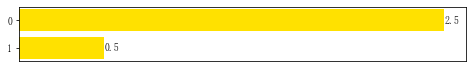

In [11]:
from maysics.explainer import Shapley
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shapley = Shapley(f)
shapley.fit([[1, 0], [2, 1]])
shapley.show()

本模块中的以上两种解释方法：SHAP和Shapley，目前只能解释有一个预测值的回归模型